In [24]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
%ls

In [ ]:
!pip install numba 

In [27]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

data, data_labels = [],[]
H, W = 360, 540
for file in os.listdir('./PCIA_Resolved_imgs'):
  if(file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png') ):
    image = cv2.imread('./PCIA_Resolved_imgs/'+file)
    if image.shape[0] < H:
      continue
    #print(file)
    img_new = cv2.resize(image, (W,H), interpolation = cv2.INTER_AREA)
    data.append(img_new)
    data_labels.append(0)

print(len(data))


101


In [ ]:
len(data)

101

In [28]:
active_count = 0
#files_read = []
for file in sorted(os.listdir('./PCIA_Active_imgs')):
  if active_count > 110:
    break
  image = cv2.imread('./PCIA_Active_imgs/'+file)
  if image.shape[0] < H:
      continue
  img_new = cv2.resize(image, (W,H), interpolation = cv2.INTER_AREA)
  # print(file)
  # print(image.shape)
  data.append(img_new)
  data_labels.append(1)
  active_count += 1

print(active_count)

111


In [29]:
from sklearn.utils import shuffle
np.random.seed(0)
data, data_labels = np.array(data), np.array(data_labels)
N = len(data)
# Train - 80% (15% of which is used as validation data)
# Test - 20%
s_data, s_data_labels = shuffle(data, data_labels, random_state = 7)
x_train, y_train = s_data[:(N*69)//100, :,:,:], s_data_labels[:(N*69)//100]
x_val, y_val = s_data[(N*69)//100:(N*80)//100 , :,:,:], s_data_labels[(N*69)//100:(N*80)//100]
x_test, y_test = s_data[(N*80)//100: , :,:,:], s_data_labels[(N*80)//100:]
#x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(146, 360, 540, 3)
(43, 360, 540, 3)
(23, 360, 540, 3)


In [30]:
np.sum(y_train)

76

In [ ]:
conv1 = layers.Conv2D(64, (3, 3), strides= 2,padding='same')(input_img) #28 x 28 x 32
    conv1 = layers.LeakyReLU(alpha = 0.2)(conv1)
    conv1 = layers.BatchNormalization()(conv1)

     |████████████████████████████████| 51kB 4.5MB/s 


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model



In [32]:
def conv_block(x, num_filters, pool = False):
  if pool:
    x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(num_filters, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  return x


In [33]:
# functional defn of model
input_img = layers.Input(shape = (360, 540, 3))
out = conv_block(input_img, 64)
# x = layers.Conv2D(num_filters, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001))(inp)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
out_res1 = conv_block(out, 128, pool = True)
##---two consecutive conv_blocks+skip connection---##
out = conv_block(out_res1, 128)
out = conv_block(out, 128)+out_res1
##--/\--##
out = conv_block(out, 256, pool =True)
out_res2 = conv_block(out, 512, pool = True)
##two consecutive conv_blocks+skip connection
out = conv_block(out_res2, 512)
out = conv_block(out, 512)+out_res2
##classifier head
out = layers.MaxPooling2D((4,4))(out)
out = layers.Flatten()(out)
out = layers.Dropout(0.2)(out)
outputs = layers.Dense(2, activation="softmax")(out)
model = Model(input_img, outputs)
#print(len(new_model.layers))
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 540, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 360, 540, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 360, 540, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 360, 540, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

THINGS TO TRY:


*   Add data augmentaion and try again
*   Try reducing active_count
*   Mobilenetv2, other baseline models
*   Try XGBoost with pre-trained, fine tuned feat_extractors.




In [35]:
def sigmoidal_decay(e, start=0, end =50, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    
    if e > end:
        return lr_end
    
    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))
    
    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

In [41]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
mc = ModelCheckpoint('weights.best.keras', monitor='val_acc', save_best_only=True)
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e))

In [39]:
import keras
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#one_hot_label = to_categorical(y_train)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
aug = ImageDataGenerator(rescale = 1/255.0, width_shift_range=0.15, horizontal_flip =True)
#aug = ImageDataGenerator(rotation_range=15, zoom_range=0.15, width_shift_range=0.2,height_shift_range=0.2,
#                         rescale = 1/255.0, horizontal_flip=True, vertical_flip = True,fill_mode="nearest")
# train the network
# H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
# 	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
# 	epochs=EPOCHS)
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


In [45]:
hist = model.fit(x_train, to_categorical(y_train), validation_data= (x_val, to_categorical(y_val)),
                 batch_size = 16, epochs=40, verbose=2)

Epoch 1/40
10/10 - 25s - loss: 47.8053 - accuracy: 0.4863 - val_loss: 61812.7188 - val_accuracy: 0.3913
Epoch 2/40
10/10 - 13s - loss: 10.4254 - accuracy: 0.7397 - val_loss: 3263.1438 - val_accuracy: 0.6957
Epoch 3/40
10/10 - 13s - loss: 8.8239 - accuracy: 0.6986 - val_loss: 148.3899 - val_accuracy: 0.9130
Epoch 4/40
10/10 - 13s - loss: 10.5697 - accuracy: 0.6370 - val_loss: 192.4441 - val_accuracy: 0.7826
Epoch 5/40
10/10 - 13s - loss: 19.1827 - accuracy: 0.6233 - val_loss: 3915.8308 - val_accuracy: 0.6087
Epoch 6/40
10/10 - 13s - loss: 9.1200 - accuracy: 0.7808 - val_loss: 329.1591 - val_accuracy: 0.7826
Epoch 7/40
10/10 - 13s - loss: 6.0525 - accuracy: 0.7945 - val_loss: 74.0026 - val_accuracy: 0.8696
Epoch 8/40
10/10 - 13s - loss: 6.7337 - accuracy: 0.7808 - val_loss: 356.4718 - val_accuracy: 0.6087
Epoch 9/40
10/10 - 13s - loss: 8.2873 - accuracy: 0.8082 - val_loss: 52.6586 - val_accuracy: 0.7826
Epoch 10/40
10/10 - 13s - loss: 6.9592 - accuracy: 0.8288 - val_loss: 90.7435 - val_a

In [ ]:
model.layers[-18].name

'conv5_block3_preact_bn'

In [ ]:
#Unfreezing outer layers and for further fine tuning.
for layer in model.layers[-18:]:
        if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
hist_1 = model.fit(x_train, to_categorical(y_train), validation_data= (x_val, to_categorical(y_val)), epochs=25, verbose=2)

Epoch 1/25
5/5 - 6s - loss: 0.3954 - accuracy: 0.8701 - val_loss: 0.3795 - val_accuracy: 0.8400
Epoch 2/25
5/5 - 2s - loss: 0.3238 - accuracy: 0.8961 - val_loss: 0.3749 - val_accuracy: 0.8800
Epoch 3/25
5/5 - 2s - loss: 0.3473 - accuracy: 0.8571 - val_loss: 0.3729 - val_accuracy: 0.8400
Epoch 4/25
5/5 - 2s - loss: 0.3008 - accuracy: 0.9026 - val_loss: 0.3960 - val_accuracy: 0.8800
Epoch 5/25
5/5 - 2s - loss: 0.2800 - accuracy: 0.9091 - val_loss: 0.3639 - val_accuracy: 0.8800
Epoch 6/25
5/5 - 2s - loss: 0.2583 - accuracy: 0.9156 - val_loss: 0.3592 - val_accuracy: 0.9200
Epoch 7/25
5/5 - 2s - loss: 0.2316 - accuracy: 0.9416 - val_loss: 0.3806 - val_accuracy: 0.8800
Epoch 8/25
5/5 - 2s - loss: 0.2303 - accuracy: 0.9351 - val_loss: 0.3653 - val_accuracy: 0.8000
Epoch 9/25
5/5 - 2s - loss: 0.2061 - accuracy: 0.9416 - val_loss: 0.3842 - val_accuracy: 0.7200
Epoch 10/25
5/5 - 2s - loss: 0.1730 - accuracy: 0.9740 - val_loss: 0.3807 - val_accuracy: 0.8800
Epoch 11/25
5/5 - 2s - loss: 0.1851 - a

In [46]:
##testing on original model:
preds = model.predict(x_test)

In [ ]:
y_test

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1])

In [ ]:
to_categorical(y_test)

In [47]:
#y_pred = np.array([1 if num > 0.5 else 0 for num in preds])
# print(predictions)
scores = np.max(preds, axis = 1)
y_pred = np.argmax(preds, axis=1)
print(y_pred)
print(y_test)
print(y_pred.shape)
print(np.mean(y_pred == y_test))

[1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0
 1 1 0 0 1 1]
[1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0
 1 1 0 0 1 1]
(43,)
0.813953488372093


In [49]:
print(scores)

[1.         1.         1.         1.         1.         1.
 1.         0.99999976 1.         1.         1.         1.
 1.         0.9940096  1.         0.99999154 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.9997253  1.         1.
 1.        ]


In [50]:
mis_class = (np.where(y_pred != y_test))[0]
mis_class

array([ 1,  7,  8, 15, 18, 27, 31, 32])

In [51]:
y_test[mis_class]

array([1, 0, 0, 0, 0, 1, 0, 0])

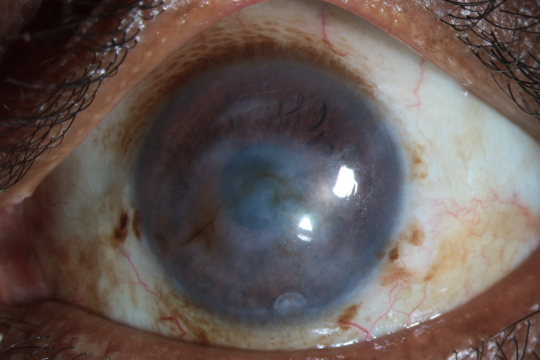

In [56]:
cv2_imshow(x_test[7])

In [19]:
for i in mis_class:
  cv2_imshow(x_test[i])

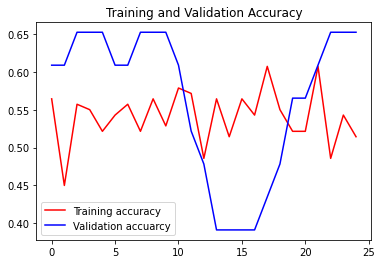

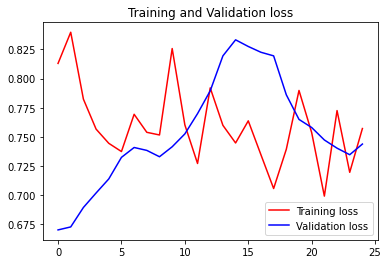

In [ ]:
##PLOTS
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training accuracy")

plt.plot(epochs, val_acc, 'b', label = "Validation accuarcy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

In [ ]:
feat_model = keras.Model(model.input, model.get_layer("avg_pool").output)
feature_extractor = feat_model.predict(x_train)
train_features = feature_extractor.reshape(feature_extractor.shape[0], -1)

feature_vec = feat_model.predict(x_test)
test_features = feature_vec.reshape(feature_vec.shape[0], -1)

In [ ]:
print(train_features.shape)
print(y_train.shape)

(154, 512)
(154,)


In [ ]:

import xgboost as xgb
model_xg = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

eval_set = [(train_features, y_train), (test_features, y_test)]
model_xg.fit(train_features, y_train, early_stopping_rounds = 10, eval_metric=["logloss"],
          eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

[1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1
 0 1 1 1 0 0 0 1]
[1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1
 0 1 1 1 0 0 1 1]
Accuracy: 0.8222222222222222


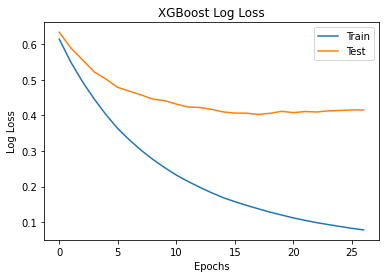

In [ ]:
import matplotlib.pyplot as plt


# make predictions for test data
preds = model_xg.predict(test_features)
print(preds)
print(y_test)
acc = np.mean(preds == y_test)
print(f"Accuracy: {acc}")

results = model_xg.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()

In [ ]:
mis_class = (np.where(preds != y_test))[0]
mis_class

array([ 6, 11, 19, 21, 23, 26, 27, 43])

In [ ]:
preds[mis_class]

array([1, 0, 1, 1, 0, 0, 1, 0])

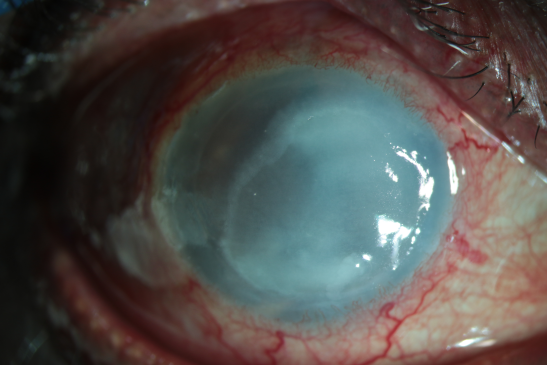

In [ ]:
cv2_imshow(x_test[11])